#Cassava Leaf Disease Classification Project#

# Part 1: Import Packages and the Dataset##

####Import Packages###

In [3]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from google.colab import files
import pandas as pd
import io
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from google.colab import drive
import json
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
import tensorflow as tf
import cv2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from sklearn.model_selection import train_test_split
import re
from functools import partial
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random

###Mount the Drive###

In [4]:
import zipfile
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [5]:
f = open('/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/kaggle.json')
label_name = json.load(f)
label_name

{'key': '083bf009d9ae3ccc39aef8c4627c217d', 'username': 'yunxuanzeng'}

###Load the tfrecords###

***Define Some Important Variables***
* Batch_Size: 32
* Labels: 5 different labels in total 
* tf.data.AUTOTUNE: promp the tf.data runtime to tune the value dynamically at runtime. 
* train_path: the path of training dataset directory
* test_path: the path of testing dataset directory
* Image_Size: 512*512

In [6]:
Batch_Size = 32
labels = list(label_name.keys())
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_path = '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train*.tfrec'
test_path = '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/test_tfrecordsld_test*.tfrec'
image_size_Original = [512, 512]
image_size= 224

In [7]:
print(labels)

['username', 'key']


***Preprocess the Image***
* Decode a JPEG-encoded image to a uint8 tensor.
* Divide by 255 to get 0-1 representation 

In [8]:
def preprocess_img(img):
  img_decode = tf.image.decode_jpeg(img, channels = 3)
  img_255 = tf.cast(img_decode, tf.float32)/255.0
  img_res = tf.reshape(img_255, [*image_size_Original,3])
  img_resize = tf.image.resize(img_res, [image_size, image_size])
  return img_resize

***Read the tfrecord***

In [9]:
def read_tfrecord(example, labeled):
  tfrecord_format = {"image":tf.io.FixedLenFeature([], tf.string),
                     "target":tf.io.FixedLenFeature([], tf.int64),
                     } if labeled else {
                     "image": tf.io.FixedLenFeature([], tf.string),
                     "image_name": tf.io.FixedLenFeature([], tf.string)
                     }
  example = tf.io.parse_single_example(example, tfrecord_format)
  
  img_res = preprocess_img(example['image'])
  
  if labeled:
    label = tf.cast(example['target'], tf.int32)
    return img_res, label
  else: 
    id = example['image_name']
    return img_res, id

***Load the dataset***

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

###Splitting Strategy###

In [11]:
train_list = tf.io.gfile.glob(train_path)
test_list = tf.io.gfile.glob(test_path)
train_list, test_list

(['/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train00-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train01-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train02-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train03-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train04-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train05-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train06-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train07-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train08-1338.tfrec',
  '/conten

In [12]:
df_training, df_validation = train_test_split(train_list,
                                              test_size=0.2, random_state=42)
df_testing = tf.io.gfile.glob(test_list)

In [13]:
len(df_training), len(df_validation), len(df_testing)

(12, 4, 0)

In [14]:
df_training, df_validation, df_testing

(['/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train13-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train11-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train08-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train09-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train02-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train15-1327.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train04-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train07-1338.tfrec',
  '/content/gdrive/Shareddrives/data2040_midterm_project/my_data/data/train_tfrecords/ld_train10-1338.tfrec',
  '/conten

###Image Augmentation###

In [15]:
def train_augmentation(image, label):
    # image_augmentation 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_crop(image,[image_size, image_size, 3])
    image = tf.image.random_brightness(image, max_delta = 0.5)
    image = tf.image.random_saturation(image, lower = 5, upper = 10)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_jpeg_quality(image, 75, 95)
    return image, label

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

###Load the dataset###

* repeat: repeats this dataset so each original value is seen infinitely. 
* shuffle: randomly shuffles the elements of this dataet. 
* prefetch: allows later elements to be prepared while the current element is being processed.

In [17]:
def get_training_dataset():
    df_train = load_dataset(df_training, labeled=True)  
    df_train = df_train.map(train_augmentation, num_parallel_calls=AUTOTUNE)  
    df_train = df_train.repeat()
    df_train = df_train.shuffle(2048)
    df_train = df_train.batch(Batch_Size)
    df_train = df_train.prefetch(AUTOTUNE) 
    return df_train

In [18]:
def get_validation_dataset(ordered=False):
    df_valid = load_dataset(df_validation, labeled=True, ordered=ordered) 
    df_valid = df_valid.batch(Batch_Size)
    df_valid = df_valid.cache()
    df_valid = df_valid.prefetch(AUTOTUNE)
    return df_valid

In [19]:
def get_test_dataset(ordered=False):
    df_test = load_dataset(df_testing, labeled=False, ordered=ordered)
    df_test = df_test.batch(Batch_Size)
    df_test = df_test.prefetch(AUTOTUNE)
    return df_test

In [20]:
def counting(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [21]:
num_training = counting(df_training)
num_valid = counting(df_validation)
num_test = counting(df_testing)

print('This Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    num_training, num_valid, num_test))

This Dataset: 16045 training images, 5352 validation images, 0.0 (unlabeled) test images


In [22]:
df_train = get_training_dataset()
df_valid = get_validation_dataset()
df_test = get_test_dataset()

In [23]:
df_train, df_valid, df_test

(<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>)

In [24]:
print("Training dataset:")
for image, label in df_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
    print("Training dataset labels:", label.numpy())
print("Validation dataset:")
for image, label in df_valid.take(3):
    print(image.numpy().shape, label.numpy().shape)
    print("Validation dataset labels:", label.numpy())
print("Test dataset:")
for image, idnum in df_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
    print("Test data IDs:", idnum.numpy().astype('U')) 

Training dataset:
(32, 224, 224, 3) (32,)
Training dataset labels: [1 3 3 3 3 1 1 3 3 4 2 3 3 3 3 3 2 3 3 3 4 2 3 0 3 4 3 0 2 3 4 3]
(32, 224, 224, 3) (32,)
Training dataset labels: [3 3 2 3 3 4 3 3 3 3 4 3 1 3 3 3 3 0 4 3 3 3 3 3 3 3 1 3 3 1 3 3]
(32, 224, 224, 3) (32,)
Training dataset labels: [3 3 2 0 3 3 0 3 3 3 0 4 1 3 3 2 1 2 3 3 1 3 3 3 4 4 3 3 3 0 3 3]
Validation dataset:
(32, 224, 224, 3) (32,)
Validation dataset labels: [0 3 1 3 1 3 3 1 3 1 2 0 3 3 4 3 3 3 2 4 3 4 1 3 2 0 3 2 3 2 3 3]
(32, 224, 224, 3) (32,)
Validation dataset labels: [4 3 1 4 0 3 3 3 3 3 1 3 3 3 3 2 2 2 1 3 2 4 3 3 2 1 2 3 4 2 3 3]
(32, 224, 224, 3) (32,)
Validation dataset labels: [3 3 3 4 3 3 3 4 3 3 3 3 3 1 3 3 3 3 1 3 1 2 3 0 3 3 3 3 3 3 4 3]
Test dataset:


# Part 2: Model

## Baseline Model

In [28]:
from keras.applications.vgg16 import VGG16

def build_base():
  base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(224,224,3))
  base_model.trainable = False
  model = base_model.output
  model = Flatten()(model)
  out = Dense(5, activation="softmax")(model)
  model = Model(inputs = base_model.input, outputs = out)
  return model

In [29]:
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size

In [30]:
model_base = build_base()
model_base.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_base.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=10)

58892288/58889256 [==============================] - 2s 0us/step
Epoch 1/10
501/501 [==============================] - 89s 130ms/step - loss: 1.9107 - accuracy: 0.5157 - val_loss: 3.5716 - val_accuracy: 0.1974
Epoch 2/10
501/501 [==============================] - 58s 116ms/step - loss: 1.6631 - accuracy: 0.5488 - val_loss: 2.2147 - val_accuracy: 0.5114
Epoch 3/10
501/501 [==============================] - 59s 118ms/step - loss: 1.6340 - accuracy: 0.5636 - val_loss: 1.8224 - val_accuracy: 0.6306
Epoch 4/10
501/501 [==============================] - 57s 114ms/step - loss: 1.6070 - accuracy: 0.5689 - val_loss: 3.5014 - val_accuracy: 0.6368
Epoch 5/10
501/501 [==============================] - 56s 112ms/step - loss: 1.5865 - accuracy: 0.5681 - val_loss: 2.8621 - val_accuracy: 0.6400
Epoch 6/10
501/501 [==============================] - 55s 111ms/step - loss: 1.5709 - accuracy: 0.5789 - val_loss: 2.6531 - val_accuracy: 0.6441
Epoch 7/10
501/501 [==============================] - 54s 108ms/s

## VGG

### Test0: VGG

In [31]:
from keras.applications.vgg16 import VGG16

def build_vgg():
  base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(256,256,3))
  for layer in base_model.layers[:-5]:
        layer.trainable = False

  model = base_model.output
  model = Flatten()(model)

  model = Dense(512, activation='relu')(model)
  # model = BatchNormalization()(model)
  model = Dropout(rate=0.3)(model)

  model = Dense(256, activation='relu')(model)
  model = Dropout(rate=0.3)(model)

  model = Dense(128, activation='relu')(model)
  model = Dropout(rate=0.3)(model)

  out = Dense(5, activation='softmax')(model)
  model = Model(inputs = base_model.input, outputs = out)
  return model
model_vgg = build_vgg()
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [32]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96)

opt = keras.optimizers.Adam(learning_rate = lr_schedule)

# earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size

In [33]:
model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model_vgg.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=20)

Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_mobile3.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_mobile3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_mobile3.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_mobile3.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

### Test 1: VGG
- https://github.com/ak3ra/Cassavify/blob/master/cassavify3.0.ipynb
- https://www.kaggle.com/maifeeulasad/cassava-leaf-disease-vgg/notebook

In [32]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights = 'imagenet', include_top = False, input_shape=(256,256,3))
transfer_layer = model.get_layer('block5_pool')
transfer_layer.output

conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())

new_model.add(Dense(512, activation='relu'))
# head = tf.keras.layers.BatchNormalization()(head)
new_model.add(Dropout(0.3))
new_model.add(Dense(64, activation='relu'))

new_model.add(Dense(5, activation='softmax'))

In [33]:
optimizer = Adam(lr=1e-5)
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']
# model.trainable = False
'''for layer in base_model.layers:
    layer.trainable = True
    
base_model.layers[0].trainable = False
base_model.layers[1].trainable = False'''
for layer in conv_model.layers[:15]:
    layer.trainable = False

In [34]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 325       
Total params: 31,525,573
Trainable params: 23,890,309
Non-trainable params: 7,635,264
__________________________________

In [35]:
Batch_Size = 256
steps_per_epoch = num_training // Batch_Size + 1
valid_steps = num_valid // Batch_Size + 1
history_new = new_model.fit(df_train, steps_per_epoch = steps_per_epoch, validation_data = df_valid, validation_steps = valid_steps, epochs = 30)

Epoch 1/30
63/63 [==============================] - 67s 967ms/step - loss: 1.1790 - accuracy: 0.6082 - val_loss: 1.1024 - val_accuracy: 0.6347
Epoch 2/30
63/63 [==============================] - 55s 887ms/step - loss: 0.9884 - accuracy: 0.6446 - val_loss: 0.9952 - val_accuracy: 0.6631
Epoch 3/30
63/63 [==============================] - 55s 874ms/step - loss: 0.9361 - accuracy: 0.6574 - val_loss: 1.0240 - val_accuracy: 0.6495
Epoch 4/30
63/63 [==============================] - 54s 865ms/step - loss: 0.9032 - accuracy: 0.6657 - val_loss: 0.9934 - val_accuracy: 0.6549
Epoch 5/30
63/63 [==============================] - 51s 817ms/step - loss: 0.8698 - accuracy: 0.6758 - val_loss: 0.9154 - val_accuracy: 0.6773
Epoch 6/30
63/63 [==============================] - 52s 824ms/step - loss: 0.8440 - accuracy: 0.6897 - val_loss: 1.0044 - val_accuracy: 0.6439
Epoch 7/30
63/63 [==============================] - 51s 816ms/step - loss: 0.8265 - accuracy: 0.6906 - val_loss: 0.9092 - val_accuracy: 0.6783

KeyboardInterrupt: ignored

### Test 2: VGG

In [128]:
from keras.applications.vgg16 import VGG16

def build_vgg():
  base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(256,256,3))
  for layer in base_model.layers[:10]:
      layer.trainable = False

  model = base_model.output
  model = Flatten()(model)

  model = Dense(512, activation='relu')(model)
  model = Dropout(rate=0.3)(model)

  model = Dense(256, activation='relu')(model)
  model = Dropout(rate=0.3)(model)

  model = Dense(128, activation='relu')(model)
  model = Dropout(rate=0.3)(model)

  out = Dense(5, activation='softmax')(model)
  model = Model(inputs = base_model.input, outputs = out)
  return model

model_vgg = build_vgg()
model_vgg.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [129]:
opt = keras.optimizers.Adam(learning_rate = 1e-5)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5)

Batch_Size = 64
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size

In [130]:
model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model_vgg.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=100)

Epoch 1/50
250/250 [==============================] - 79s 270ms/step - loss: 1.3135 - accuracy: 0.5440 - val_loss: 0.9898 - val_accuracy: 0.6465
Epoch 2/50
250/250 [==============================] - 55s 221ms/step - loss: 1.0963 - accuracy: 0.6169 - val_loss: 0.9650 - val_accuracy: 0.6585
Epoch 3/50
250/250 [==============================] - 60s 242ms/step - loss: 1.0297 - accuracy: 0.6453 - val_loss: 0.9024 - val_accuracy: 0.6623
Epoch 4/50
250/250 [==============================] - 55s 220ms/step - loss: 1.0123 - accuracy: 0.6444 - val_loss: 0.9217 - val_accuracy: 0.6694
Epoch 5/50
250/250 [==============================] - 38s 152ms/step - loss: 0.9952 - accuracy: 0.6454 - val_loss: 0.9901 - val_accuracy: 0.6608
Epoch 6/50
250/250 [==============================] - 39s 158ms/step - loss: 0.9970 - accuracy: 0.6400 - val_loss: 0.9260 - val_accuracy: 0.6762
Epoch 7/50
250/250 [==============================] - 36s 143ms/step - loss: 0.9600 - accuracy: 0.6547 - val_loss: 0.9688 - val_ac

### Test3 VGG

In [81]:
from keras.applications.vgg16 import VGG16

def create_vgg(dropout_rate=0.2):
  base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(224,224,3))
  for layer in base_model.layers[:10]:
    layer.trainable = False

  model = base_model.output
  model = Flatten()(model)

  model = Dense(512, activation='relu')(model)
  model = Dropout(rate=dropout_rate)(model)

  model = Dense(256, activation='relu')(model)
  model = Dropout(rate=dropout_rate)(model)

  model = Dense(128, activation='relu')(model)
  model = Dropout(rate=dropout_rate)(model)

  out = Dense(5, activation='softmax')(model)
  model = Model(inputs = base_model.input, outputs = out)
  return model

model_vgg = create_vgg()
model_vgg.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

In [82]:
opt = keras.optimizers.Nadam(learning_rate = 1e-5)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5)

Batch_Size = 64
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size

In [83]:
model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model_vgg.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=20)

Epoch 1/20
250/250 [==============================] - 54s 153ms/step - loss: 1.2305 - accuracy: 0.5732 - val_loss: 1.0503 - val_accuracy: 0.6502
Epoch 2/20
250/250 [==============================] - 38s 151ms/step - loss: 1.0556 - accuracy: 0.6314 - val_loss: 0.9199 - val_accuracy: 0.6589
Epoch 3/20
250/250 [==============================] - 38s 152ms/step - loss: 1.0149 - accuracy: 0.6432 - val_loss: 1.0399 - val_accuracy: 0.6427
Epoch 4/20
250/250 [==============================] - 38s 153ms/step - loss: 0.9735 - accuracy: 0.6471 - val_loss: 1.0541 - val_accuracy: 0.6280
Epoch 5/20
250/250 [==============================] - 39s 155ms/step - loss: 0.9116 - accuracy: 0.6735 - val_loss: 0.8414 - val_accuracy: 0.6924
Epoch 6/20
250/250 [==============================] - 38s 153ms/step - loss: 0.8968 - accuracy: 0.6712 - val_loss: 0.8343 - val_accuracy: 0.6958
Epoch 7/20
250/250 [==============================] - 38s 154ms/step - loss: 0.8689 - accuracy: 0.6928 - val_loss: 0.7623 - val_ac

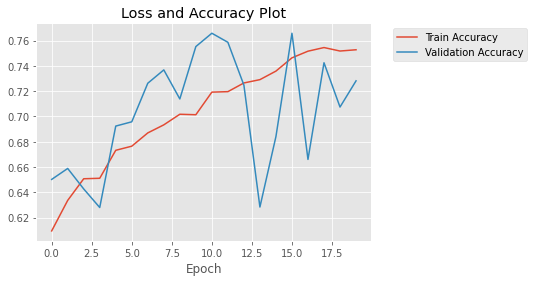

In [85]:
import matplotlib.pyplot as plt
import numpy as np

N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

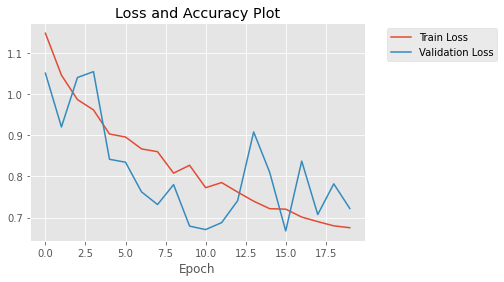

In [86]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

## Test3: VGG 

In [44]:
from keras.applications.vgg16 import VGG16

def create_vgg():
    base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(224,224,3))
    for layer in base_model.layers:
        layer.trainable = True

    model = base_model.output
    model = Flatten()(model)

    model = Dense(256, activation='relu')(model)
    model = Dropout(rate=0.5)(model)

    model = Dense(128, activation='relu')(model)
    model = Dropout(rate=0.5)(model)

    out = Dense(5, activation='softmax')(model)
    model = Model(inputs = base_model.input, outputs = out)
  
    return model

model_vgg = create_vgg()

In [47]:
opt = keras.optimizers.Nadam(learning_rate = 1e-5)
model_vgg.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [48]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50, restore_best_weights = True)

In [49]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR = model_vgg.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=300, callbacks = [es])

Epoch 1/300
125/125 [==============================] - 38s 238ms/step - loss: 1.4447 - accuracy: 0.4693 - val_loss: 1.0781 - val_accuracy: 0.6143
Epoch 2/300
125/125 [==============================] - 30s 237ms/step - loss: 1.1541 - accuracy: 0.6017 - val_loss: 1.0754 - val_accuracy: 0.6410
Epoch 3/300
125/125 [==============================] - 30s 237ms/step - loss: 1.1147 - accuracy: 0.6235 - val_loss: 0.9676 - val_accuracy: 0.6456
Epoch 4/300
125/125 [==============================] - 30s 240ms/step - loss: 1.1270 - accuracy: 0.6059 - val_loss: 1.2400 - val_accuracy: 0.5877
Epoch 5/300
125/125 [==============================] - 30s 241ms/step - loss: 1.0602 - accuracy: 0.6428 - val_loss: 1.0018 - val_accuracy: 0.6608
Epoch 6/300
125/125 [==============================] - 30s 237ms/step - loss: 1.0393 - accuracy: 0.6308 - val_loss: 1.2371 - val_accuracy: 0.5366
Epoch 7/300
125/125 [==============================] - 30s 238ms/step - loss: 1.0479 - accuracy: 0.6301 - val_loss: 0.9418 -

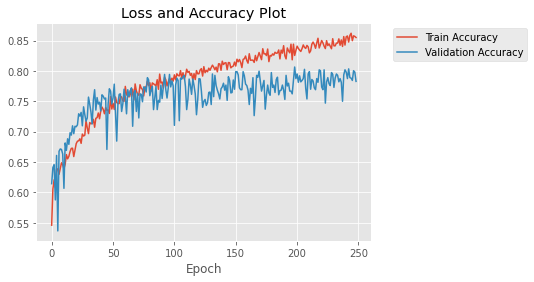

In [50]:
import matplotlib.pyplot as plt
import numpy as np
N = 249
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

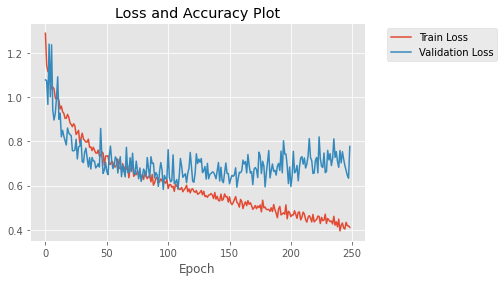

In [51]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [53]:
# save model
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

In [54]:
save_model(model_vgg, 'model_vgg')

Saved trained model at /content/saved_models/model_vgg.h5 


## MobileNetV2

### test: MN1

In [111]:
def make_headmodel_1():
    base_model = tf.keras.applications.MobileNetV2(input_shape = (224,224,3), include_top = False)
    
    for layer in base_model.layers:
      if isinstance(layer, keras.layers.normalization.BatchNormalization):
          layer.trainable = False

    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)

    model = Dense(128, activation = 'relu')(model) 
    model = Dropout(0.4)(model)
                                                                      
    model = Dense(64, activation = 'relu')(model)
    model = Dropout(0.4)(model)

    out = Dense(5, activation = 'softmax')(model)
    
    model = Model(inputs = base_model.input, outputs = out)
    return model

model = make_headmodel_1()
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_18[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [112]:
# opt = keras.optimizers.Adam(learning_rate = 0.00001)
opt = keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [113]:
Batch_Size = 64
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_mobile2 = model.fit(df_train, steps_per_epoch = steps_per_epoch, 
                      validation_data = df_valid, validation_steps = valid_steps, epochs = 50)

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 1.3037 - accuracy: 0.5901

ValueError: ignored

In [ ]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_mobile2.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_mobile2.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_mobile2.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_mobile2.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

### Test: MN3

In [214]:
def make_headmodel_1():
    base_model = tf.keras.applications.MobileNetV2(input_shape = (224,224,3), include_top = False)
    
    for layer in base_model.layers:
      if isinstance(layer, keras.layers.normalization.BatchNormalization):
          layer.trainable = False

    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)

    model = Dense(64, activation = 'relu')(model) 
    model = Dropout(0.4)(model)
                                                                      
    # model = Dense(32, activation = 'relu')(model)
    # model = Dropout(0.4)(model)

    out = Dense(5, activation = 'softmax')(model)
    
    model = Model(inputs = base_model.input, outputs = out)
    return model

model = make_headmodel_1()
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_31[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [215]:
# opt = keras.optimizers.Adam(learning_rate = 0.00001)
opt = keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [216]:
Batch_Size = 64
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_mobile3 = model.fit(df_train, steps_per_epoch = steps_per_epoch, 
                      validation_data = df_valid, validation_steps = valid_steps, epochs = 100)

Epoch 1/100
250/250 [==============================] - 47s 143ms/step - loss: 1.4145 - accuracy: 0.4890 - val_loss: 1.2169 - val_accuracy: 0.6175
Epoch 2/100
250/250 [==============================] - 36s 143ms/step - loss: 1.2317 - accuracy: 0.5691 - val_loss: 1.0532 - val_accuracy: 0.6186
Epoch 3/100
250/250 [==============================] - 35s 140ms/step - loss: 1.1461 - accuracy: 0.6066 - val_loss: 1.2167 - val_accuracy: 0.5584
Epoch 4/100
250/250 [==============================] - 35s 142ms/step - loss: 1.1502 - accuracy: 0.6040 - val_loss: 1.0823 - val_accuracy: 0.6536
Epoch 5/100
250/250 [==============================] - 35s 139ms/step - loss: 1.0665 - accuracy: 0.6363 - val_loss: 1.0840 - val_accuracy: 0.6352
Epoch 6/100
250/250 [==============================] - 35s 141ms/step - loss: 1.0813 - accuracy: 0.6277 - val_loss: 1.0191 - val_accuracy: 0.6555
Epoch 7/100
250/250 [==============================] - 37s 147ms/step - loss: 1.0417 - accuracy: 0.6429 - val_loss: 0.9726 -

KeyboardInterrupt: ignored

In [ ]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_mobile3.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_mobile3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_mobile3.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_mobile3.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

## inception resnet

In [217]:
from tensorflow.keras.applications import InceptionResNetV2
def make_basemodel_IR2():
    base_model = InceptionResNetV2(input_shape = (image_size,image_size,3), 
                                include_top = False, weights = 'imagenet')
    
    for layer in base_model.layers:
      layer.trainble = False
  
    return base_model

base_model_IR = make_basemodel_IR2()

In [218]:
def make_headmodel_IR2(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head) 

  head = tf.keras.layers.Dense(96, activation = "relu",kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.5)(head)

  head = tf.keras.layers.Dense(32, activation = "relu",kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.5)(head)

  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model_IR = make_headmodel_IR2(base_model_IR)

In [219]:
opt = keras.optimizers.Adam(1e-4)
model_IR.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [220]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR = model_IR.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=10)

Epoch 1/10
125/125 [==============================] - 63s 308ms/step - loss: 49.9883 - accuracy: 0.4212 - val_loss: 42.1950 - val_accuracy: 0.6220
Epoch 2/10
125/125 [==============================] - 35s 281ms/step - loss: 39.9802 - accuracy: 0.5749 - val_loss: 32.7804 - val_accuracy: 0.6303
Epoch 3/10
125/125 [==============================] - 35s 282ms/step - loss: 30.7402 - accuracy: 0.5902 - val_loss: 24.4896 - val_accuracy: 0.6517
Epoch 4/10
125/125 [==============================] - 35s 284ms/step - loss: 22.7651 - accuracy: 0.6123 - val_loss: 17.6075 - val_accuracy: 0.6562
Epoch 5/10
125/125 [==============================] - 35s 281ms/step - loss: 16.1868 - accuracy: 0.6235 - val_loss: 12.3713 - val_accuracy: 0.6562
Epoch 6/10
125/125 [==============================] - 35s 277ms/step - loss: 11.3016 - accuracy: 0.6498 - val_loss: 8.4767 - val_accuracy: 0.6745
Epoch 7/10
125/125 [==============================] - 34s 271ms/step - loss: 7.8872 - accuracy: 0.6337 - val_loss: 6.10

ValueError: ignored

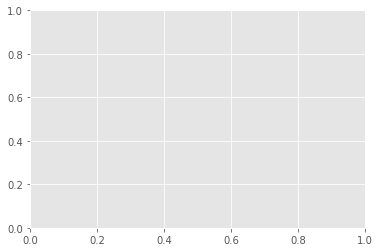

In [221]:
import matplotlib.pyplot as plt
import numpy as np

N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

## Resnet

In [245]:
import matplotlib.pyplot as plt

def plot_training_my(df_train, df_valid, lr, ax=None):
    base_model = tf.keras.applications.InceptionV3(input_shape=(image_size,image_size,3),
                                               include_top=False,
                                               weights='imagenet')
    for layer in base_model.layers:
      layer.trainble = False

      head = base_model.output

      head = tf.keras.layers.GlobalMaxPooling2D()(head)

      head = Flatten()(head)
      head = Dense(64, activation = "relu", kernel_regularizer = 'l2')(head)
      head = Dropout(0.5)(head)

      head = tf.keras.layers.Dense(5, activation = "softmax")(head)
      model = Model(inputs=base_model.input, outputs=head)
    
    
      opt = keras.optimizers.Nadam(learning_rate = lr)

      model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      Batch_Size =128
      steps_per_epoch = num_training // Batch_Size
      valid_steps = num_valid // Batch_Size
      history = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                                validation_data=df_valid, 
                                validation_steps=valid_steps, 
                                epochs=20)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    print('train_accuracy', train_acc, 'val_accuracy', val_acc)
    ax.plot(train_acc, label='train_accuracy')
    ax.plot(val_acc, label='val_accuracy')
    ax.legend()
    return train_acc, val_acc
      
lr = [1e-3, 1e-4, 1e-5, 1e-6]

Epoch 1/20
125/125 [==============================] - 47s 169ms/step - loss: 2.6386 - accuracy: 0.5567 - val_loss: 1017.4669 - val_accuracy: 0.1448
Epoch 2/20
125/125 [==============================] - 18s 143ms/step - loss: 1.6858 - accuracy: 0.6223 - val_loss: 2.2981 - val_accuracy: 0.6303
Epoch 3/20
125/125 [==============================] - 18s 146ms/step - loss: 1.4109 - accuracy: 0.6208 - val_loss: 1.1922 - val_accuracy: 0.6433
Epoch 4/20
125/125 [==============================] - 18s 148ms/step - loss: 1.1958 - accuracy: 0.6518 - val_loss: 1.4318 - val_accuracy: 0.5213
Epoch 5/20
125/125 [==============================] - 18s 145ms/step - loss: 1.1397 - accuracy: 0.6294 - val_loss: 1.0666 - val_accuracy: 0.6502
Epoch 6/20
125/125 [==============================] - 18s 144ms/step - loss: 1.0550 - accuracy: 0.6444 - val_loss: 1.2620 - val_accuracy: 0.6349
Epoch 7/20
125/125 [==============================] - 18s 145ms/step - loss: 1.1911 - accuracy: 0.6095 - val_loss: 18.0376 - va

KeyboardInterrupt: ignored

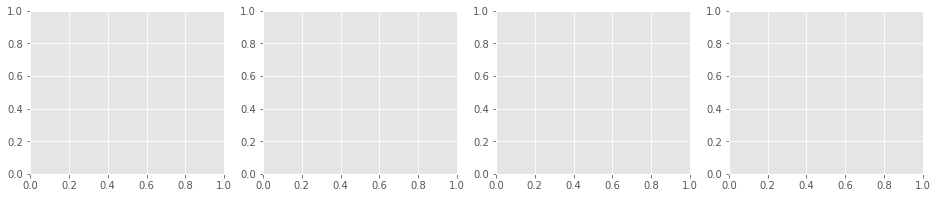

In [246]:
fig, axes = plt.subplots(1, 4, figsize = (16, 3))

train_accs = []
val_accs = []
for i in range(4):
      keras.backend.clear_session()
      train_acc, val_acc = plot_training_my(df_train, df_valid, lr[i])
      train_accs.append(train_acc)
      val_accs.append(val_acc)
print(max(train_accs), max(val_accs))
fig.tight_layout()  

## ResNet50

In [23]:
from tensorflow.keras.applications import InceptionResNetV2
def make_basemodel_RS():
    base_resnet = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape=(image_size, image_size, 3),
                        weights="imagenet")
    
    for layer in base_resnet.layers:
      layer.trainble = False
  
    return base_resnet

base_model_RS = make_basemodel_RS()

In [24]:
def make_headmodel_RS(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head) 

  head = tf.keras.layers.Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.6)(head)
 
  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model_RS = make_headmodel_RS(base_model_RS)

In [25]:
opt = keras.optimizers.Adam(1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001, cooldown = 2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=60, restore_best_weights = True)
model_RS.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [26]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR = model_RS.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=200, callbacks = [es, reduce_lr])

Epoch 1/200
125/125 [==============================] - 41s 216ms/step - loss: 141.7628 - accuracy: 0.4536 - val_loss: 128.0427 - val_accuracy: 0.1090
Epoch 2/200
125/125 [==============================] - 25s 202ms/step - loss: 119.9490 - accuracy: 0.5662 - val_loss: 105.1992 - val_accuracy: 0.6021
Epoch 3/200
125/125 [==============================] - 25s 202ms/step - loss: 100.0421 - accuracy: 0.5978 - val_loss: 85.5504 - val_accuracy: 0.6082
Epoch 4/200
125/125 [==============================] - 26s 205ms/step - loss: 80.7141 - accuracy: 0.6050 - val_loss: 67.9086 - val_accuracy: 0.6052
Epoch 5/200
125/125 [==============================] - 26s 210ms/step - loss: 63.1697 - accuracy: 0.6272 - val_loss: 51.8040 - val_accuracy: 0.5602
Epoch 6/200
125/125 [==============================] - 25s 204ms/step - loss: 48.1994 - accuracy: 0.6505 - val_loss: 38.7363 - val_accuracy: 0.6380
Epoch 7/200
125/125 [==============================] - 25s 202ms/step - loss: 35.9889 - accuracy: 0.6467 - 

In [27]:
for layer in model_RS.layers:
  layer.trainable = True

for layer in model_RS.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f40c0199b50> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f40c018ff50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f40c0114b50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f40c012fd90> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f40c0153850> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f40c00b4f90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f40c00b4ed0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f40c0114350> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f40c002f0d0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f40c004fb50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f40d9551d10> True
<tensorflow.python.keras.layers.normaliz

In [28]:
opt = keras.optimizers.Adam(1e-5)
model_RS.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [29]:
Batch_Size = 64
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IRF = model_RS.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=50)

Epoch 1/50
250/250 [==============================] - 62s 208ms/step - loss: 0.6571 - accuracy: 0.8186 - val_loss: 0.8130 - val_accuracy: 0.7617
Epoch 2/50
250/250 [==============================] - 51s 205ms/step - loss: 0.6736 - accuracy: 0.8126 - val_loss: 0.8881 - val_accuracy: 0.7078
Epoch 3/50
250/250 [==============================] - 52s 208ms/step - loss: 0.6408 - accuracy: 0.8254 - val_loss: 0.8613 - val_accuracy: 0.7229
Epoch 4/50
250/250 [==============================] - 51s 203ms/step - loss: 0.6513 - accuracy: 0.8219 - val_loss: 0.8796 - val_accuracy: 0.7225
Epoch 5/50
250/250 [==============================] - 50s 202ms/step - loss: 0.6442 - accuracy: 0.8158 - val_loss: 0.8870 - val_accuracy: 0.7101
Epoch 6/50
250/250 [==============================] - 51s 204ms/step - loss: 0.6662 - accuracy: 0.8154 - val_loss: 0.8518 - val_accuracy: 0.7334
Epoch 7/50
250/250 [==============================] - 51s 204ms/step - loss: 0.6409 - accuracy: 0.8228 - val_loss: 0.8686 - val_ac

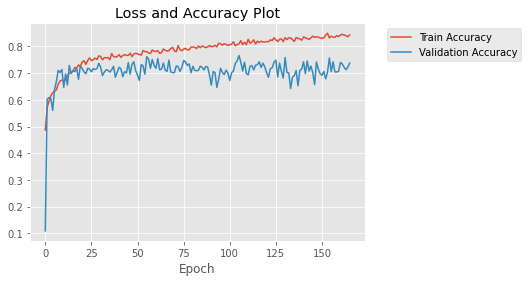

In [32]:
import matplotlib.pyplot as plt
import numpy as np
N = 166
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

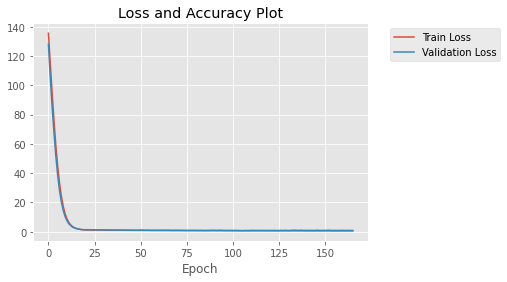

In [33]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [34]:
# save model
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

In [35]:
save_model(model_RS, 'ResNet_model')

Saved trained model at /content/saved_models/ResNet_model.h5 


# Tuning: Resnet

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
def make_basemodel_RS():
    base_resnet = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape=(image_size, image_size, 3),
                        weights="imagenet")
    
    for layer in base_resnet.layers:
      layer.trainble = False
  
    return base_resnet

base_model_RS = make_basemodel_RS()

In [ ]:
def make_headmodel_RS(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head) 

  head = tf.keras.layers.Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.6)(head)
 
  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model_RS = make_headmodel_RS(base_model_RS)

In [ ]:
opt = keras.optimizers.Adam(1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001, cooldown = 2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=60, restore_best_weights = True)
model_RS.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR = model_RS.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=200, callbacks = [es, reduce_lr])

In [43]:
# tuning learning rate
import matplotlib.pyplot as plt

def plot_training_resnet_lr(df_train, df_valid, lr, ax=None):
    base_model = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape=(image_size, image_size, 3),
                        weights="imagenet")
    
    for layer in base_model.layers:
      layer.trainble = False
    
    head = base_model.output

    head = tf.keras.layers.GlobalMaxPooling2D()(head) 

    head = tf.keras.layers.Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
    head = Dropout(0.6)(head)
  
    head = tf.keras.layers.Dense(5, activation = "softmax")(head)
    model = Model(inputs=base_model.input, outputs=head)
    
    opt = keras.optimizers.Adam(lr)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001, cooldown = 2)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    Batch_Size = 128
    steps_per_epoch = num_training // Batch_Size
    valid_steps = num_valid // Batch_Size
    history = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                        validation_data=df_valid, validation_steps=valid_steps, epochs=10, callbacks = [reduce_lr])


    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax.plot(train_acc, label='train_accuracy')
    ax.plot(val_acc, label='val_accuracy')
    ax.legend()
    return [max(train_acc), max(val_acc), lr]
      
lr = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

Epoch 1/10
125/125 [==============================] - 37s 209ms/step - loss: 102.7757 - accuracy: 0.5358 - val_loss: 19.6168 - val_accuracy: 0.6105
Epoch 2/10
125/125 [==============================] - 25s 202ms/step - loss: 13.2708 - accuracy: 0.6027 - val_loss: 4.7984 - val_accuracy: 0.6082
Epoch 3/10
125/125 [==============================] - 25s 203ms/step - loss: 4.2821 - accuracy: 0.5914 - val_loss: 3.2277 - val_accuracy: 0.6098
Epoch 4/10
125/125 [==============================] - 26s 208ms/step - loss: 3.2488 - accuracy: 0.6095 - val_loss: 3.3682 - val_accuracy: 0.6113
Epoch 5/10
125/125 [==============================] - 27s 214ms/step - loss: 2.9209 - accuracy: 0.6055 - val_loss: 2.4850 - val_accuracy: 0.6098
Epoch 6/10
125/125 [==============================] - 26s 206ms/step - loss: 2.2476 - accuracy: 0.6126 - val_loss: 1.9422 - val_accuracy: 0.6105
Epoch 7/10
125/125 [==============================] - 25s 204ms/step - loss: 1.9070 - accuracy: 0.6119 - val_loss: 1.9530 - va

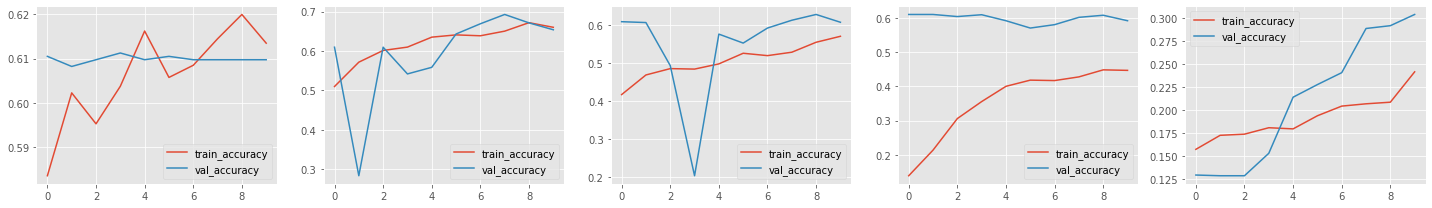

In [44]:
fig, axes = plt.subplots(1, 5, figsize = (20, 3))

res_lr = []
for i in range(5):
    keras.backend.clear_session()
    res_lr.append(plot_training_resnet_lr(df_train, df_valid, lr[i], axes[i]))
fig.tight_layout() 

In [25]:
# tuning learning rate
import matplotlib.pyplot as plt

def plot_training_resnet_dp(df_train, df_valid, dp, ax=None):
    base_model = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape=(image_size, image_size, 3),
                        weights="imagenet")
    
    for layer in base_model.layers:
      layer.trainble = False
    
    head = base_model.output

    head = tf.keras.layers.GlobalMaxPooling2D()(head) 

    head = tf.keras.layers.Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
    head = Dropout(dp)(head)
  
    head = tf.keras.layers.Dense(5, activation = "softmax")(head)
    model = Model(inputs=base_model.input, outputs=head)
    
    opt = keras.optimizers.Adam(1e-5)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001, cooldown = 2)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    Batch_Size = 128
    steps_per_epoch = num_training // Batch_Size
    valid_steps = num_valid // Batch_Size
    history = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                        validation_data=df_valid, validation_steps=valid_steps, epochs=10, callbacks = [reduce_lr])


    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax.plot(train_acc, label='train_accuracy')
    ax.plot(val_acc, label='val_accuracy')
    ax.legend()
    return [max(train_acc), max(val_acc), dp]
      
dp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

Epoch 1/10
125/125 [==============================] - 38s 213ms/step - loss: 145.2589 - accuracy: 0.3861 - val_loss: 142.4579 - val_accuracy: 0.0983
Epoch 2/10
125/125 [==============================] - 26s 205ms/step - loss: 141.2643 - accuracy: 0.4968 - val_loss: 141.9615 - val_accuracy: 0.1479
Epoch 3/10
125/125 [==============================] - 26s 206ms/step - loss: 138.8363 - accuracy: 0.5235 - val_loss: 144.1456 - val_accuracy: 0.1395
Epoch 4/10
125/125 [==============================] - 26s 210ms/step - loss: 136.6342 - accuracy: 0.5059 - val_loss: 141.7087 - val_accuracy: 0.2828
Epoch 5/10
125/125 [==============================] - 27s 217ms/step - loss: 134.0157 - accuracy: 0.5622 - val_loss: 134.1196 - val_accuracy: 0.5998
Epoch 6/10
125/125 [==============================] - 26s 207ms/step - loss: 131.9793 - accuracy: 0.5605 - val_loss: 130.9332 - val_accuracy: 0.5762
Epoch 7/10
125/125 [==============================] - 26s 206ms/step - loss: 129.7787 - accuracy: 0.5662 -

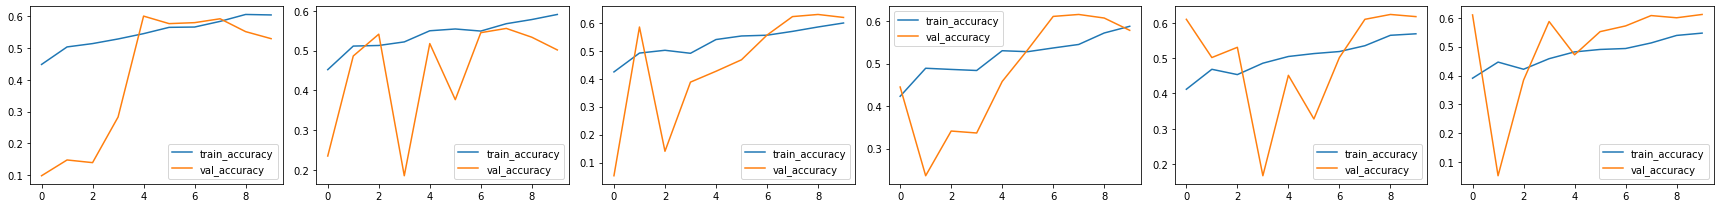

In [27]:
fig, axes = plt.subplots(1, 6, figsize = (24, 3))

res_dp = []
for i in range(6):
    keras.backend.clear_session()
    res_dp.append(plot_training_resnet_dp(df_train, df_valid, dp[i], axes[i]))
fig.tight_layout() 

In [28]:
# tuning learning rate
import matplotlib.pyplot as plt

def plot_training_resnet_n(df_train, df_valid, n, ax=None):
    base_model = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape=(image_size, image_size, 3),
                        weights="imagenet")
    
    for layer in base_model.layers:
      layer.trainble = False
    
    head = base_model.output

    head = tf.keras.layers.GlobalMaxPooling2D()(head) 

    head = tf.keras.layers.Dense(n, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
    head = Dropout(0.7)(head)
  
    head = tf.keras.layers.Dense(5, activation = "softmax")(head)
    model = Model(inputs=base_model.input, outputs=head)
    
    opt = keras.optimizers.Adam(1e-5)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001, cooldown = 2)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    Batch_Size = 128
    steps_per_epoch = num_training // Batch_Size
    valid_steps = num_valid // Batch_Size
    history = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                        validation_data=df_valid, validation_steps=valid_steps, epochs=10, callbacks = [reduce_lr])


    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax.plot(train_acc, label='train_accuracy')
    ax.plot(val_acc, label='val_accuracy')
    ax.legend()
    return [max(train_acc), max(val_acc), n]
      
n = [64, 256, 512, 1024]

Epoch 1/10
125/125 [==============================] - 38s 214ms/step - loss: 46.4042 - accuracy: 0.2691 - val_loss: 38.9345 - val_accuracy: 0.5617
Epoch 2/10
125/125 [==============================] - 26s 208ms/step - loss: 40.0914 - accuracy: 0.3853 - val_loss: 38.1180 - val_accuracy: 0.5998
Epoch 3/10
125/125 [==============================] - 26s 206ms/step - loss: 37.5102 - accuracy: 0.3716 - val_loss: 36.7656 - val_accuracy: 0.2912
Epoch 4/10
125/125 [==============================] - 26s 211ms/step - loss: 36.3342 - accuracy: 0.3694 - val_loss: 35.8342 - val_accuracy: 0.3956
Epoch 5/10
125/125 [==============================] - 27s 217ms/step - loss: 35.7174 - accuracy: 0.4368 - val_loss: 35.4791 - val_accuracy: 0.4253
Epoch 6/10
125/125 [==============================] - 26s 208ms/step - loss: 35.3898 - accuracy: 0.4526 - val_loss: 35.1083 - val_accuracy: 0.4832
Epoch 7/10
125/125 [==============================] - 26s 207ms/step - loss: 35.0885 - accuracy: 0.4969 - val_loss: 34

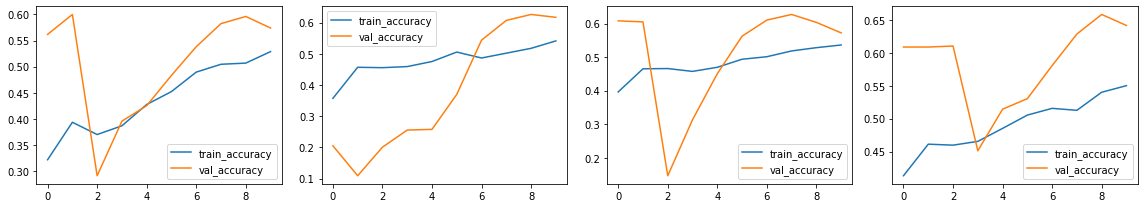

In [29]:
fig, axes = plt.subplots(1, 4, figsize = (16, 3))

res_n = []
for i in range(4):
    keras.backend.clear_session()
    res_dp.append(plot_training_resnet_n(df_train, df_valid, n[i], axes[i]))
fig.tight_layout() 

In [37]:
# tuning learning rate
import matplotlib.pyplot as plt

def plot_training_resnet_dp_n(df_train, df_valid, dp, n, ax=None):
    base_model = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape=(image_size, image_size, 3),
                        weights="imagenet")
    
    for layer in base_model.layers:
      layer.trainble = False
    
    head = base_model.output

    head = tf.keras.layers.GlobalMaxPooling2D()(head) 

    head = tf.keras.layers.Dense(n, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
    head = Dropout(dp)(head)
  
    head = tf.keras.layers.Dense(5, activation = "softmax")(head)
    model = Model(inputs=base_model.input, outputs=head)
    
    opt = keras.optimizers.Adam(1e-5)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001, cooldown = 2)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    Batch_Size = 128
    steps_per_epoch = num_training // Batch_Size
    valid_steps = num_valid // Batch_Size
    history = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                        validation_data=df_valid, validation_steps=valid_steps, epochs=10, callbacks = [reduce_lr])


    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax.plot(train_acc, label='train_accuracy')
    ax.plot(val_acc, label='val_accuracy')
    ax.legend()
    ax.set_title("n={}, dropout={}".format(n, dp))
    return [max(train_acc), max(val_acc), dp, n]
dp = [0.5, 0.6, 0.7]     
n = [64, 256, 512, 1024]

Epoch 1/10
125/125 [==============================] - 38s 213ms/step - loss: 43.1754 - accuracy: 0.2491 - val_loss: 38.0236 - val_accuracy: 0.2858
Epoch 2/10
125/125 [==============================] - 26s 206ms/step - loss: 38.1577 - accuracy: 0.4272 - val_loss: 45.3194 - val_accuracy: 0.1075
Epoch 3/10
125/125 [==============================] - 26s 206ms/step - loss: 36.7876 - accuracy: 0.4292 - val_loss: 36.8982 - val_accuracy: 0.3727
Epoch 4/10
125/125 [==============================] - 26s 211ms/step - loss: 35.9453 - accuracy: 0.4104 - val_loss: 35.9147 - val_accuracy: 0.2325
Epoch 5/10
125/125 [==============================] - 27s 214ms/step - loss: 35.4627 - accuracy: 0.4442 - val_loss: 35.1114 - val_accuracy: 0.4771
Epoch 6/10
125/125 [==============================] - 26s 207ms/step - loss: 35.0239 - accuracy: 0.5173 - val_loss: 34.7198 - val_accuracy: 0.5084
Epoch 7/10
125/125 [==============================] - 25s 204ms/step - loss: 34.7122 - accuracy: 0.5057 - val_loss: 34

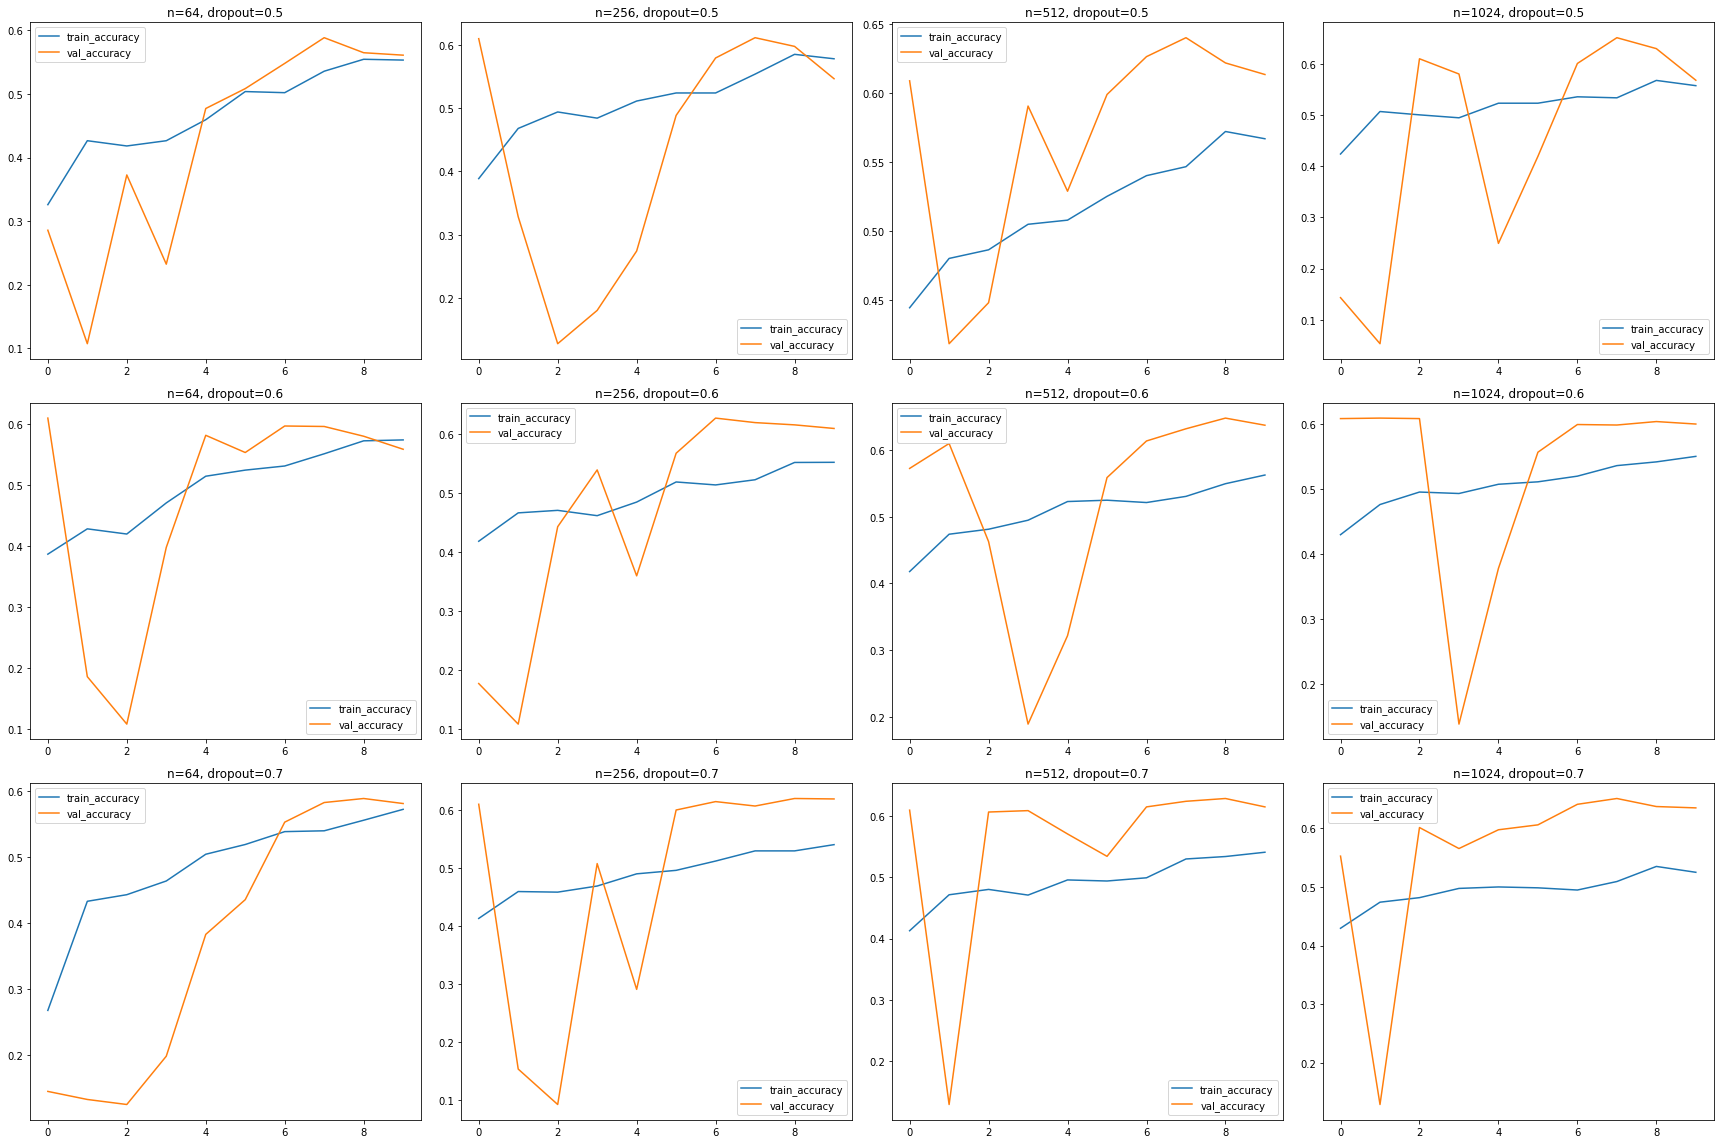

In [38]:
fig, axes = plt.subplots(3, 4, figsize = (24, 16))

res_dp_n = []
for i in range(3):
    for j in range(4):
        keras.backend.clear_session()
        res_dp_n.append(plot_training_resnet_dp_n(df_train, df_valid, dp[i], n[j], axes[i][j]))
fig.tight_layout() 